In [1]:
import bayesnewton
import jax
import objax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from convertbng.util import convert_bng, convert_lonlat
import time
from sklearn.model_selection import train_test_split
import datetime
import math   
from jax import vmap
from scipy.stats import beta


import cv2
import sys, os
sys.path.append('../Utils')
import model_utils as mutils
import kernels_definitions as kerns
%load_ext autoreload
%autoreload 2

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [9]:
#DATA VARIABLES
SYSTEMS_NUM = 120
TIMESTEPS_NUM = 35295  #THIS IS EXACTLY ONE YEAR
TRAIN_FRAC = 2  #IF TRAIN_FRAC > 1 THEN IT BECOMES THE LENGTH OF THE TEST SET
GRID_PIXELS = 15

#OPTIMISATION VARIABLES
LR_ADAM =  0.1095990416571735
LR_NEWTON = 0.2944896882908768
ITERS = 1000

#GP Variables
VAR_Y = 0.996641303535278
LEN_SPACE = 1.1445954129246831

#PERIODIC KERNEL
VAR_PERIOD = 0.14694909160883585
VAR_MATERN = 0.14694909160883585
LEN_MATERN = 5

#Want to use a sparse approximation
SPARSE = True
#Should we optimise the inducing points
OPT_Z = True  # will be set to False if SPARSE=SPARSE

#use a mean field approximation?
MEAN_FIELD = False
MINI_BATCH_SIZE = None #none if you don't want them
TEST_STATIONS = 271 - 120

In [10]:
uk_pv = pd.read_csv('../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
#data_multiple.plot(legend=False)
lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])

data =  pd.read_csv('../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
#I AM SHUFFLING HERE
data_multiple = data.iloc[:,:SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()
stacked = mutils.stack_dataframe(data_multiple, lats, longs)
stacked = stacked[(stacked.latitude < 52.5) & (stacked.latitude > 50.5) & (stacked.longitude > -1) & (stacked.longitude < 1)]

capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000


In [11]:
X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])

from suncalc import get_position, get_times
date_solar = stacked.datetime.values
lon_solar = stacked.longitude.values
lat_solar = stacked.latitude.values

solar_positions = get_position(date_solar, lon_solar, lat_solar)
solar_altitude = solar_positions['altitude']

# convert to easting and northings
british_national_grid_coords = convert_bng(X[:, 1], X[:, 2])
X = np.vstack([X[:, 0],
              np.array(british_national_grid_coords[0]),
              np.array(british_national_grid_coords[1])]).T

#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)

# solar_altitudes = solar_altitude.reshape(R.shape[1], R.shape[0], 1).swapaxes(0,1)

# R = np.append(R, solar_altitudes, axis=2)

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Grid of initial inducing points')

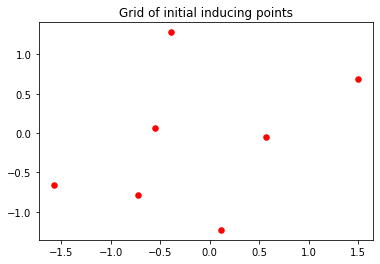

In [12]:
#train test split for 3 dimensional data
t_train, t_test, R_train, R_test, Y_train, Y_test = mutils.train_split_3d(t, R, Y, train_frac = TRAIN_FRAC, split_type = 'Cutoff')
# Y = Y[:,:,0]

#get the mask of the test points
test_mask = np.in1d(t.squeeze(), t_test.squeeze())

#Scale the data
scaled_values = mutils.scale_2d_train_test_data(R, Y, R_train, R_test, Y_train, Y_test )
R_scaler, R_scaled, R_train_scaled, R_test_scaled, _, _, _, _ = scaled_values

#here get a list of scaled coordinates (frozen because at some point in time)
R_scaled_frozen = R_scaled[0]

# #Create a grid to perform prediction/interpolation on
r1, r2, Rplot = mutils.create_grid_from_coords(R = R_scaled_frozen, t = t, R_scaler = R_scaler, N_pixels = GRID_PIXELS, date_solar = date_solar)

# z = R_scaled[2, ...]
z = R_scaled[2, ::3]


# #CHANGE THE INDUCING POINTS FOR THE SOLAR ALTITUDE TO BE EQUALLY SPACED ALONG THE TOTAL INTERVAL
# z[:,2] = np.linspace(solar_altitude.min(),solar_altitude.max(),  len(z))
    
plt.scatter(*zip(*z[:, ...]), marker='o', s=30, color='red')
plt.title('Grid of initial inducing points')


In [ ]:
kern = kerns.get_SpatioTemporal_combined(variance = VAR_PERIOD, 
                                 lengthscale_time = LEN_MATERN,
                                   lengthscale_space=[LEN_SPACE, LEN_SPACE], #[LEN_SPACE, LEN_SPACE, LEN_ALTITUDE]
                                   z=z,
                                   sparse=SPARSE,
                                   opt_z=OPT_Z,
                                   conditional='Full',
                                   matern_order = '12')


In [ ]:
if MEAN_FIELD:
    lik = bayesnewton.likelihoods.Beta(scale = 3, fix_scale=False, link='probit')
    model = bayesnewton.models.MarkovVariationalMeanFieldGP(kernel=kern, likelihood=lik, X=t_train, R=R_train_scaled, Y=Y_train)    
else:    
    lik = bayesnewton.likelihoods.Beta(scale = 3, fix_scale=False, link='probit')
    model = bayesnewton.models.MarkovVariationalGP(kernel = kern, likelihood = lik, X=t_train, Y=Y_train, R=R_train_scaled)


In [ ]:
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())

@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op(batch_ind = None):
    model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(LR_ADAM, dE)
    return E
train_op = objax.Jit(train_op)


In [ ]:
if MINI_BATCH_SIZE == None:
    number_of_minibatches = 1
    mini_batches_indices = [None] * number_of_minibatches
else:
    number_of_minibatches = int(len(t_train) / MINI_BATCH_SIZE)
    idx_set = np.arange(len(t_train))
    np.random.shuffle(idx_set)
    mini_batches_indices = np.array_split(idx_set, number_of_minibatches)

In [ ]:
import copy
model_vars = dict.fromkeys(range(ITERS))


t0 = time.time()
for i in range(1, ITERS + 1):
    for mini_batch in range(number_of_minibatches):
        if number_of_minibatches > 1:
            print(f'Doing minibatch {mini_batch}')
        loss = train_op(mini_batches_indices[mini_batch])
        
#         #LOG THE PARAMS
#         data_var = [model.vars()['(MarkovVariationalGP).kernel(SpatioTemporalMatern12).temporal_kernel(Matern12).transformed_lengthscale'].item(),
#                  model.vars()['(MarkovVariationalGP).kernel(SpatioTemporalMatern12).temporal_kernel(Matern12).transformed_variance'].item(),
#                  model.vars()['(MarkovVariationalGP).kernel(SpatioTemporalMatern12).spatial_kernel(Matern12).transformed_lengthscale'][0].item(),
#                 model.vars()['(MarkovVariationalGP).kernel(SpatioTemporalMatern12).spatial_kernel(Matern12).transformed_lengthscale'][1].item(),
#                  model.vars()['(MarkovVariationalGP).kernel(SpatioTemporalMatern12).spatial_kernel(Matern12).transformed_variance'].item(),
#                  model.vars()['(MarkovVariationalGP).likelihood(Beta).transformed_scale'].item()]

#         data_model_vars = copy.copy(data_var)
#         model_vars[i] = data_model_vars
        
        
    print('iter %2d, energy: %1.4f' % (i, loss[0]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS


In [ ]:
# calculate posterior predictive distribution via filtering and smoothing at train & test locations:
t0 = time.time()
print('calculating the posterior predictive distribution ...')
posterior_mean, posterior_var = model.predict_y(X=t, R=Rplot)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))

t2 = time.time()
print('calculating the negative log predictive density ...')
nlpd = model.negative_log_predictive_density(X=t_test, R=R_test_scaled, Y=Y_test)
t3 = time.time()
print('nlpd calculation time: %2.2f secs' % (t3-t2))
print('nlpd: %2.3f' % nlpd)


In [ ]:
# z_opt = model.kernel.z.value
# # mu = Y_scaler.inverse_transform(posterior_mean.flatten()[:, np.newaxis]).reshape(-1, GRID_PIXELS, GRID_PIXELS)
# mu = posterior_mean.reshape(TIMESTEPS_NUM, GRID_PIXELS, GRID_PIXELS)

# #get lat-lon coordinates
# grid_coord = R_scaler.inverse_transform(np.array(np.c_[r1,r2]))
# longitude_grid, latitude_grid =  convert_lonlat(grid_coord[:, 0], grid_coord[:, 1])
# longitude_sys_train, latitude_sys_train = convert_lonlat(R_train[:,:,0][0], R_train[:,:,1][0])
# longitude_z, latitude_z = convert_lonlat(R_scaler.inverse_transform(z_opt)[:,0], R_scaler.inverse_transform(z_opt)[:,1])


In [ ]:
# save_result = False
# # del model, kern, Rplot  # , var

# print('plotting ...')
# cmap = cm.viridis
# vmin = np.nanpercentile(Y, 1)
# vmax = np.nanpercentile(Y, 99)
# #get the labels for the dates
# dates = pd.to_datetime(data_multiple.datetime).dt.date
# days_index = max(96, int(((len(t) / 5) // 96) * 96)) #number of time intervals to match 5 beginnings of days

# for time_step in range(t.shape[0])[:50]:
#     f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 1]})
#     f.set_figheight(8)
#     # f.set_figwidth(8)
#     im = a0.imshow(mu[time_step], cmap=cmap, vmin=vmin, vmax=vmax,
#                    extent=[longitude_grid[0], longitude_grid[-1], latitude_grid[0], latitude_grid[-1]], origin='lower')
#     if SPARSE:
#         a0.scatter(longitude_z, latitude_z, c='r', s=60, alpha=0.5)  # plot inducing inputs
#     a0.scatter(longitude_sys_train, latitude_sys_train, cmap=cmap, vmin=vmin, vmax=vmax,
#                c=np.squeeze(Y[time_step]), s=50, edgecolors='black')
#     plt.colorbar(im, fraction=0.0348, pad=0.03, aspect=30, ax=a0)
    
#     a0.set_xlim(longitude_grid[0], longitude_grid[-1])
#     a0.set_ylim(latitude_grid[0], latitude_grid[-1])
#     a0.set_title(f'PVE at {data_multiple.datetime.unique()[time_step]}')
#     a0.set_ylabel('Latitude')
#     a0.set_xlabel('Longitude')
#     a1.vlines(t[time_step].item(), -1, 1, 'r')
#     a1.set_xlabel('time (days)')
#     a1.set_xlim(t[0], t[-1])
    
#     a1.set_xticks(np.asarray(t[1:-1:days_index ][:,0].tolist()), 
#                   labels = dates[0:-1:days_index].values,
#                      fontsize = 10)
#     plt.show()
#     plt.close(f)

## Predict on Unseen Locations

In [ ]:
data_unseen = data.iloc[:, SYSTEMS_NUM:SYSTEMS_NUM+TEST_STATIONS][:TIMESTEPS_NUM].reset_index()
capacities_unseen = uk_pv[uk_pv.ss_id_string.isin(data_unseen.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked_unseen = mutils.stack_dataframe(data_unseen, lats, longs)
stacked_unseen = stacked_unseen[(stacked_unseen.latitude < 52.5) & (stacked_unseen.latitude > 50.5) & (stacked_unseen.longitude > -1) & (stacked_unseen.longitude < 1)]

X_unseen = np.array(stacked_unseen[['epoch', 'longitude', 'latitude']])
Y_unseen = np.array(stacked_unseen[['PV']])

# convert to easting and northings
british_national_grid_coords_unseen = convert_bng(X_unseen[:, 1], X_unseen[:, 2])
X_unseen = np.vstack([X_unseen[:, 0],
              np.array(british_national_grid_coords_unseen[0]),
              np.array(british_national_grid_coords_unseen[1])]).T

#Create a space-time grid from X and Y
t, R_unseen, Y_unseen = bayesnewton.utils.create_spatiotemporal_grid(X_unseen, Y_unseen)
t = t 
R_unseen_scaled = np.tile(R_scaler.transform(R_unseen[0]), (R_unseen.shape[0],1, 1))


In [ ]:
f_mean_unseen, f_var_unseen = model.predict(X=t, R=R_unseen_scaled)

#CREATE A LOOP SO IT DOESN'T RUN OUT OF MEMORY

# f_mean_unseen = []
# f_var_unseen = []

# for i in range(len(R_unseen_scaled)):
#     f_m_un, f_var_un = model.predict(X=t, R=R_unseen_scaled[i])
#     f_mean_unseen.append(f_m_un)
#     f_var_unseen.uppend(f_var_un)

In [ ]:
N_SAMPLES_UNSEEN = 100

#Sample values of f at each point
sampled_f_unseen = np.random.normal(f_mean_unseen, f_var_unseen, size=(N_SAMPLES_UNSEEN, f_var_unseen.shape[0], f_var_unseen.shape[1]))

alpha_sampled_unseen = model.likelihood.link_fn(sampled_f_unseen) * model.likelihood.scale
beta_sampled_unseen = model.likelihood.scale - alpha_sampled_unseen

beta_samples_unseen = np.random.beta(alpha_sampled_unseen, beta_sampled_unseen, size=(alpha_sampled_unseen.shape[0], alpha_sampled_unseen.shape[1], alpha_sampled_unseen.shape[2]))
lower_bounds_beta_MC_unseen = np.quantile(beta_samples_unseen, 0.025, axis=0)
upper_bounds_beta_MC_unseen = np.quantile(beta_samples_unseen, 0.975, axis=0)


In [ ]:
#GET THE Y PREDICTIONS FROM THE F VALUES
f_mean_unseen = f_mean_unseen.reshape(f_mean_unseen.shape[0], -1, 1)
f_var_unseen = f_var_unseen.reshape(f_var_unseen.shape[0], -1, 1)

mean_y_unseen, var_y_unseen = vmap(model.likelihood.predict, (0, 0, None))(f_mean_unseen, f_var_unseen, None)
posterior_mean_unseen, posterior_var_unseen = np.squeeze(mean_y_unseen), np.squeeze(var_y_unseen)

In [ ]:
Y_unseen = Y_unseen[:,:,0]

#adjust this for the correct quantities
mae = np.nanmean(abs(np.squeeze(Y_unseen) - np.squeeze(posterior_mean_unseen)))
print(f'The MAE is {mae.round(3)}')


In [ ]:
for i in range(posterior_mean_unseen.shape[1]):
    plt.figure(figsize=(10,7))
    plt.title(f'Prediction for system {i}')

    plt.plot(np.arange(len(Y[:1000])), Y_unseen[:1000,i], "xk")
    plt.plot(np.arange(len(Y[:1000])), posterior_mean_unseen[:1000,i], c="C0", lw=2, zorder=2)
    plt.fill_between(
        np.arange(len(Y[:1000])),
        lower_bounds_beta_MC_unseen[:1000,i],
        upper_bounds_beta_MC_unseen[:1000,i],
        color="C2",
        alpha=0.2)
    

In [ ]:
model.vars()

## How much would it have produced?


In [ ]:
def calc_avg_daily_prod(productions):
    '''
    Given an array of production data for each system, calculates the average daily production for each system in kWh
    '''
    n_days = productions.shape[0] / 96
    avg_daily_prod = productions.sum(axis=0) / (n_days * 12)
    return avg_daily_prod
    
avg_daily_prod_predicted = calc_avg_daily_prod(posterior_mean_unseen)
avg_daily_prod_actual = calc_avg_daily_prod(Y_unseen)


In [ ]:
pd.Series(avg_daily_prod_actual).hist()
pd.Series(avg_daily_prod_predicted).hist()
plt.show()
pd.Series(avg_daily_prod_actual - avg_daily_prod_predicted).hist()
MAE_yearly_avg = np.mean(abs(avg_daily_prod_actual - avg_daily_prod_predicted))
print(f'The MAE on the average daily kWh over {round(posterior_mean_unseen.shape[0] / 96)} days is {round(MAE_yearly_avg, 2)}')


# Given coordinates and Capacity, how much will it produce?

In [ ]:
def estimate_production(lat, lon, capacity, historical_error, confidence_interval = 0.8):
    
    R_array_2d = np.array([[lat,lon]]) #[:, np.newaxis]
    R_array_2d_scaled = R_scaler.transform(R_array_2d)
    R_array_3d_scaled = np.repeat(R_array_2d_scaled, t.shape[0], axis=0)[:, np.newaxis]

    #duplicating to avoid issues
    mean_pred, var_pred = model.predict(X=t, R=np.repeat(R_array_3d_scaled, 2, axis = 1))
    mean_pred, var_pred = mean_pred[:,0], var_pred[:,0]
    N_SAMPLES_UNSEEN = 100

    #Sample values of f at each point
    sampled_f_pred = np.random.normal(mean_pred, var_pred, size=(N_SAMPLES_UNSEEN, var_pred.shape[0]))

    alpha_sampled_pred = model.likelihood.link_fn(sampled_f_pred) * model.likelihood.scale
    beta_sampled_pred = model.likelihood.scale - alpha_sampled_pred

    beta_samples_pred = np.random.beta(alpha_sampled_pred, beta_sampled_pred, size=(alpha_sampled_pred.shape[0], alpha_sampled_pred.shape[1]))
    lower_bounds_beta_MC_pred = np.quantile(beta_samples_pred,  (1 - confidence_interval)/2, axis=0)
    upper_bounds_beta_MC_pred = np.quantile(beta_samples_pred, 1 -(1 - confidence_interval)/2, axis=0)
    
    #GET THE Y PREDICTIONS FROM THE F VALUES
    f_mean_pred = mean_pred.reshape(mean_pred.shape[0], -1, 1)
    f_var_pred = var_pred.reshape(var_pred.shape[0], -1, 1)

    mean_y_pred, var_y_pred = vmap(model.likelihood.predict, (0, 0, None))(f_mean_pred, f_var_pred, None)
    posterior_mean_pred, posterior_var_pred = np.squeeze(mean_y_pred), np.squeeze(var_y_pred)
    
    avg_daily_prod_pred = calc_avg_daily_prod(posterior_mean_pred).item()
    avg_daily_prod_pred_kWh = avg_daily_prod_pred * capacity
    
    avg_daily_prod_pred_lower = calc_avg_daily_prod(lower_bounds_beta_MC_pred).item()
    avg_daily_prod_pred_kWh_lower = avg_daily_prod_pred_lower * capacity
    
    avg_daily_prod_pred_upper = calc_avg_daily_prod(upper_bounds_beta_MC_pred).item()
    avg_daily_prod_pred_kWh_upper = avg_daily_prod_pred_upper * capacity
    
    #GET THE UNCERTAINTIES, GIVEN BOTH BY THE UNCETAINTY BARS BUT ALSO BY THE ERRORS IN THE TEST SET
    
    print(lower_bounds_beta_MC_pred.shape)
    
    error = historical_error * capacity
    
    return avg_daily_prod_pred_kWh, error, avg_daily_prod_pred_kWh_lower, avg_daily_prod_pred_kWh_upper

cap = 0.2
lat = 0
lon = 52
historical_error = MAE_yearly_avg.item()
conf = 0.8
avg_daily_prod, error, avg_daily_prod_pred_kWh_lower, avg_daily_prod_pred_kWh_upper = estimate_production(lat, lon, cap, historical_error, confidence_interval = conf)
print(f'PAST ERROR: The Estimated Average daily production in kWh is {round(avg_daily_prod, 2)} ± {round(error, 2)} for a system of capacity {cap} kW')
print(f'GP ERROR: The Estimated Average daily production in kWh is {round(avg_daily_prod, 2)} with {conf * 100}% confidence interval given by [{round(avg_daily_prod_pred_kWh_lower, 2)}, {round(avg_daily_prod_pred_kWh_upper, 2)}] for a system of capacity {cap} kW')



# How much did parameters change?

In [ ]:
param_trajectories_transformed = pd.DataFrame(model_vars).T.dropna()
param_trajectories_transformed.to_csv('param_trajectories_transformed_3.csv')

In [ ]:
param_trajectories_transformed = pd.read_csv('param_trajectories_transformed_3.csv').iloc[:, 1:]
param_trajectories = np.log(1 + np.exp(param_trajectories_transformed))
param_trajectories.columns = ['Temporal Lengthscale', 'Kernel Variance', 'Spatial Lengthscale 1', 'Spatial Lengthscale 2', 'Spatial Variance', 'Beta Scale']
param_trajectories = param_trajectories.drop(columns = ['Spatial Variance',  'Spatial Lengthscale 2'])


ax = param_trajectories.plot(subplots=True, sharex=True, sharey=False, figsize=(7.5, 14 /1.25 ),  legend = False, fontsize = 15)
plt.suptitle('7 Optimised Points \n', fontsize=20)
ax[0].set_title('Temporal Lengthscale', fontsize = 15)
ax[1].set_title('Kernel Variance', fontsize = 15)
ax[2].set_title('Spatial Lengthscale 1', fontsize = 15)
ax[3].set_title('Beta Scale', fontsize = 15)

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel('Iteration', fontsize = 15)
ax[1].set_xlabel('Iteration', fontsize = 15)
ax[2].set_xlabel('Iteration', fontsize = 15)
ax[3].set_xlabel('Iteration', fontsize = 15)

ax[0].set_ylabel('Parameter Value', fontsize = 15)
ax[1].set_ylabel('Parameter Value', fontsize = 15)
ax[2].set_ylabel('Parameter Value', fontsize = 15)
ax[3].set_ylabel('Parameter Value', fontsize = 15)
plt.tight_layout()
plt.savefig(f'figures/param_trajectories_3.png', dpi=300, bbox_inches='tight')
